In [234]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
from datetime import datetime
from copy import deepcopy
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Import dataset
aurora_cara = pd.read_csv("Aurora v2.1 data file - caracterización.csv")
aurora_feedback = pd.read_csv("Aurora v2.1 data file - ayudaHumanitaria.csv")
aurora_monitoreo = pd.read_csv("Aurora v2.1 data file - monitoreo.csv")


In [ ]:
# functions
def loadLocalJsonDoc(filepath, dataProp=''):
    """
    return deserialised json in dictionary

    Parameters
    ----------
    filepath: file location or buffer.
    dataProp: (optional) specified property to access required data
    """
    output = {}
    with open(file=filepath, mode='r', encoding='utf-8') as f:
        json_load = json.load(f)
        if (dataProp):
            output = json_load[dataProp]
        else:
            output = json_load
    return output


def changeCountriesByExpression(country, valueDict: dict[str, str]):
    output = ""
    for key, value in valueDict.items():
        match = re.match(r"^"+key+r".$", country)
        if (match):
            return value

    return output if len(output) else country


def processCountries(countries: list[str], valueDict: dict[str, str]):
    output = []
    for country in countries:
        try:
            new_country = changeCountriesByExpression(
                country=country, valueDict=valueDict)
            output.append(new_country)
        except Exception as e:
            output.append(default_value)
    return output


def getCountriesWithCoordinates(countries: list[str], geo_countries: gpd.GeoDataFrame):
    output = {}
    for country in countries:
        try:
            filtered_country = geo_countries[geo_countries["NAME"].str.lower(
            ) == country].reindex()
            centroidValue = (filtered_country.centroid).iloc[0]
            output[country] = {"x": centroidValue.x, "y": centroidValue.y}
        except Exception as e:
            print(e)
            output[country] = {"x": default_value, "y": default_value}

    return output


def toUnixTimestamp(time, format: str = "%d/%m/%Y"):
    start = datetime(1970, 1, 1)
    target = datetime.strptime(time, format)
    in_seconds = (target - start).total_seconds()
    in_milliseconds = int(in_seconds) * 1000
    return in_milliseconds


def getCoordinate(value: str, side: str, valueDict: dict[str, tuple[int, int]], expressionDict: dict[str, str]):
    try:
        country = changeCountriesByExpression(value, expressionDict)
        return valueDict[country][side]
    except Exception as e:
        return default_value


def processFieldCoordinates(df: pd.DataFrame, columnDict: dict[str, dict[str, str]], valueDict: dict[str, tuple[int, int]], expressionDict: dict[str, str]):
    local_df = deepcopy(df)
    print(valueDict)
    for column in columnDict.keys():
        local_df[columnDict[column]["x"]] = local_df[column].str.lower().apply(
            lambda x: getCoordinate(x, "x", valueDict, expressionDict))
        local_df[columnDict[column]["y"]] = local_df[column].str.lower().apply(
            lambda x: getCoordinate(x, "y", valueDict, expressionDict))

    return local_df

In [240]:
aurora = pd.merge(aurora_cara, aurora_feedback)
aurora.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 356
Data columns (total 70 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   ¿Quién entra al sistema?                                357 non-null    object 
 1   ¿Cómo interactúa con el sistema?                        357 non-null    object 
 2   Tipo de enganche                                        0 non-null      float64
 3   UserId                                                  357 non-null    int64  
 4   InteraID                                                357 non-null    object 
 5   Inicio interacción                                      357 non-null    object 
 6   Final interacción                                       0 non-null      float64
 7   Tiempo de interacción                                   110 non-null    float64
 8   Alguien te está ayudando a conectarte   

In [567]:

# Drop observations of Aurora team phones and test registers 
aurora = aurora.drop(aurora[aurora.UserId == 311571598].index)
aurora = aurora.drop(aurora[aurora.UserId == 311398466 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311396734 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311361421 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311361350 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311361257 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311337494 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311325070 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311325038 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311272934 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 310820267 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 310543580 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 310357249 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 310191611 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 308421831 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 306028996 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311725039].index)
aurora = aurora.drop(aurora[aurora.UserId == 311719001 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311718121].index)
aurora = aurora.drop(aurora[aurora.UserId == 311699383 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311696700 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 312179120 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311965863 ].index)
aurora = aurora.drop(aurora[aurora.UserId == 311965863 ].index)

In [566]:
#Variable of date in date format
aurora["Inicio interacción"] = pd.to_datetime(
aurora["Inicio interacción"], format='%Y-%m-%d %H:%M:%S', errors='coerce', utc=True).dt.strftime('%Y-%m-%d')
#aurora = aurora[aurora["Inicio interacción"] < '2023-10-29']

In [194]:
#Rename variables 
newColumns = {  'UserId' : 'objectid',
                'Edad'	: 'e06_edad',
                'Género' :	'e07_gener',
                'Latitud' : 'lat',
                'Longitud' : 'lon',
                "¿En qué país naciste?" : 'e08_pais_',
                'Otro país de nacimiento'	: 'e09_otro_p',
                '¿En qué país iniciaste tu viaje actual?'	: 'e10_pais_',
                'Otro país de inicio'	: 'e11_otro_p',
                '¿En qué país vivías hace un año?'	 : 'e12_pais_',
                'Otro país'	: 'e13_otro_p',
                'Restringir una o más raciones de alimentos' :	'e15__has_',
                'Dormir a la intemperie' :	'e16__tu_',
                'Ha necesitado asistencia médica' : 'asistencia_medica',
                '¿Cuántas personas te acompañan en tu viaje?' :	'e17__cua',
                'Hay niños, niñas o adolescentes'	 : 'e18__entr',
                'Total NNA'	: 'e19_cu',
                'NNA de 0 a 5' :	'e20__cua',
                'NNA de 6 a 11' :	'e21__cua',
                'NNA de 12 a 17'	: 'e22__cua',
                'Lugar interacción'	: 'e24__me_c',
                'Mujer embarazo viajando' : 'm01__en_t',
                'Mujer lactando viajando' : 'lactante',
                'Tienes alguna enfermedad crónica'	: 'm02__en_t',
                'Tienes alguna condición de discapacidad'	: 'm03__dent',
                'Cuáles han sido tus 3 principales necesidades': 'necesidades', 
                '¿Recibiste ayuda humanitaria en el lugar actual?' : 'm09__acce',
                'Cual ayuda humanitaria' :	'm12__cua',       
                'Qué tan fácil fue acceder a la ayuda' :	'm14_respec',
                'Qué tan satisfecho te sientes respecto a la ayuda' : 'm15__que',
               'Recomendarías la ayuda ' : 'm16_de_acu',
               'Cual ayuda humanitaria NNA' :	'm18_me_con',      
               'NNA: Qué tan fácil fue acceder a la ayuda' : 'm19_respec',
               'NNA: Qué tan satisfecho te sientes respecto a la ayuda' :	'm20__que',
               'NNA: Recomendarías la ayuda' : 'm21_de_acu',

}

aurora_carto = aurora.rename(columns=newColumns)

In [ ]:
available_countries = [x.lower() for x in list(set(list(aurora_carto["e08_pais_"].unique(
)) + list(aurora_carto["e10_pais_"].unique()) + list(aurora_carto["e12_pais_"].unique()))) if type(x) == str]

countries_dict = loadLocalJsonDoc("defaults/countries_dict.json")

available_countries = processCountries(available_countries, countries_dict)

# adding coordinates value
country_data_path = "simplecache::https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip"

country_df = ""

with fsspec.open(country_data_path) as file:
    country_df = gpd.read_file(file)


country_df

countriesWithCoordinates = getCountriesWithCoordinates(
    available_countries, country_df)
country_column_dict = loadLocalJsonDoc("defaults/country_column_dict.json")
aurora_carto = processFieldCoordinates(
    aurora_carto, country_column_dict, countriesWithCoordinates, countries_dict)
aurora_carto['lon_eng'] = aurora_carto['lon']
aurora_carto['lat_eng'] = aurora_carto['lat']
aurora_carto['longitude'] = aurora_carto['lon']
aurora_carto['latitude'] = aurora_carto['lat']

In [159]:
#filling missing values
aurora_carto.fillna(999999, inplace=True)

In [224]:
#Create the variable timeunix
def toUnixTimestamp(time, format:str = "%d/%m/%Y"):
    start = datetime(1970, 1, 1)
    target = datetime.strptime(time, format)
    in_seconds = (target - start).total_seconds()
    in_milliseconds = int(in_seconds) * 1000
    return in_milliseconds
aurora_carto["timeunix"] = aurora_carto["Inicio interacción"].apply(lambda x: toUnixTimestamp(time=x, format="%Y-%m-%d"))


In [161]:

columns = aurora_carto.columns.tolist()

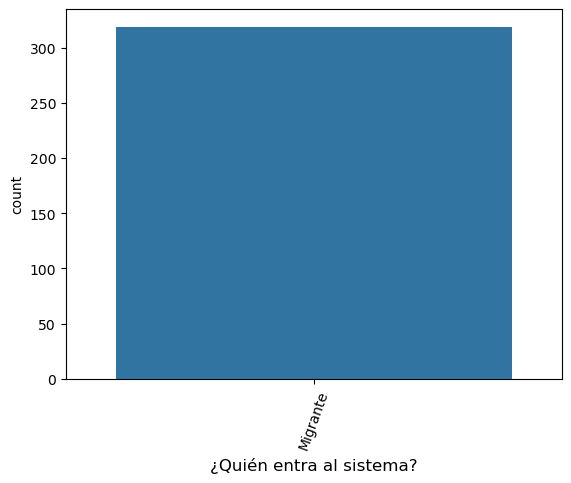

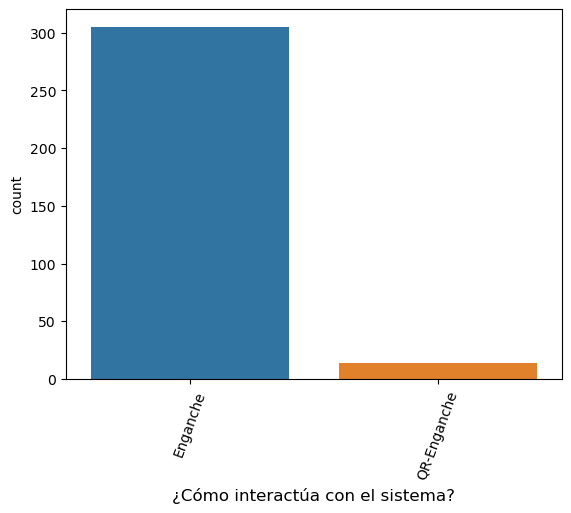

ValueError: min() arg is an empty sequence

<Figure size 640x480 with 0 Axes>

In [195]:
for column in columns:
  sns.countplot(x=column, data=aurora_carto, order = aurora_carto[column].value_counts().index)
  plt.xticks(rotation=70, fontsize=10)
  plt.xlabel(column, fontsize=12)
#  plt.title(f'[{column}]', fontsize=12)
  plt.show()
  plt.clf()

In [196]:
#database for Carto
aurora_carto.to_csv('lacro_oct_2023.csv', encoding='utf-8', index=False)

Daily report

In [565]:
aurora = pd.read_csv ("Aurora v2.1 data file - caracterización (1).csv")

In [568]:


unpivoted = aurora.groupby(['Nombre gestor', 'Inicio interacción'])[
    'UserId'].count().reset_index()
pivoted = unpivoted.pivot(
    columns='Inicio interacción',
    index=['Nombre gestor'],
    values='UserId')
# Reset the index of the pivoted DataFrame
pivoted = pivoted.reset_index()
pivoted

Inicio interacción,Nombre gestor,2023-10-16,2023-10-17,2023-10-18,2023-10-19,2023-10-20,2023-10-21,2023-10-23,2023-10-24,2023-10-25,2023-10-26,2023-10-27,2023-10-28,2023-10-30,2023-10-31,2023-11-01,2023-11-02,2023-11-03,2023-11-04
0,Glenis Barragán,NaN,NaN,NaN,1.0,2.0,NaN,1.0,3.0,2.0,9.0,3.0,NaN,NaN,6.0,4.0,3.0,3.0,NaN
1,José Herrera,NaN,NaN,NaN,NaN,NaN,7.0,10.0,12.0,NaN,9.0,NaN,NaN,NaN,10.0,NaN,13.0,NaN,NaN
2,José Luis Gaete,5.0,3.0,NaN,NaN,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN
3,Luis David Calderón,NaN,NaN,NaN,5.0,5.0,NaN,3.0,4.0,1.0,2.0,NaN,NaN,NaN,NaN,1.0,4.0,3.0,NaN
4,Luisa Solis,1.0,11.0,10.0,8.0,5.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,3.0,3.0,13.0,7.0,NaN
5,Marianela Varela,NaN,NaN,NaN,5.0,8.0,NaN,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,1.0
6,Massiel Rodriguez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
7,Rosa Casanova,NaN,NaN,1.0,2.0,3.0,NaN,5.0,5.0,2.0,7.0,2.0,NaN,NaN,1.0,NaN,5.0,1.0,NaN
8,Sheila Muñoz,3.0,8.0,1.0,2.0,5.0,1.0,3.0,NaN,NaN,NaN,4.0,5.0,NaN,NaN,5.0,6.0,7.0,NaN
9,Valentina Medina,3.0,2.0,2.0,3.0,NaN,NaN,1.0,1.0,NaN,NaN,3.0,3.0,NaN,4.0,3.0,4.0,7.0,NaN


In [569]:
excel_file = 'gestores.xlsx'
pivoted.to_excel(excel_file, index=False)

Needs and feedback

In [561]:
feedback = aurora[[ 'UserId', 'Latitud', 'Longitud', 'Cual ayuda humanitaria', 'Qué tan fácil fue acceder a la ayuda', 
                     'Qué tan satisfecho te sientes respecto a la ayuda', 'Recomendarías la ayuda ','¿Recibiste ayuda humanitaria en el lugar actual?']].reset_index()



In [562]:
# Rename variables according to Carto names (first round)

newColumns = { 
                'UserId' : 'Id', 
                'Latitud' : 'Lat', 
                'Longitud' : 'Lon',
                'Cual ayuda humanitaria' : 'Ayuda', 
                'Qué tan fácil fue acceder a la ayuda' : 'Acceso', 
                'Qué tan satisfecho te sientes respecto a la ayuda' : 'Satisfaccion',
                'Recomendarías la ayuda ' : 'Recomendacion',
                '¿Recibiste ayuda humanitaria en el lugar actual?' : 'Ayuda_lugaractual'
}


feedback = feedback.rename(columns=newColumns)

In [563]:
feedback['Ayuda'] = feedback['Ayuda'].str.split('|')
feedback['Acceso'] = feedback['Acceso'].str.split('|')
feedback['Satisfaccion'] = feedback['Satisfaccion'].str.split('|')
feedback['Recomendacion'] = feedback['Recomendacion'].str.split('|')

df = pd.DataFrame(feedback)

df = df[df.apply(lambda row: all(row[['Ayuda', 'Acceso', 'Satisfaccion', 'Recomendacion']].str.len() == row[['Ayuda', 'Acceso', 'Satisfaccion','Recomendacion']].str.len().iloc[0]), axis=1)]

df=df.explode(['Ayuda', 'Acceso','Satisfaccion','Recomendacion'])

df


In [558]:
excel_file = 'ayuda.xlsx'
df1.to_excel(excel_file, index=False)

In [ ]:
aurora['necesidades'] = aurora['necesidades'].str.split('|')
prueba = aurora.explode('necesidades')
prueba.head()

In [51]:
prueba["Cuáles han sido tus 3 principales necesidades"].head()

0     12
0     12
0     13
1    NaN
2      1
Name: Cuáles han sido tus 3 principales necesidades, dtype: object

In [56]:
# use dictionary for necessities

nec_dict = {
1: "Agua",
2: "Alimentación o kit de alimentación", 
3: "Alojamiento temporal", 
4: "Asistencia legal",
5: "Ayuda psicológica",
6: "Dinero en efectivo", 
7: "Duchas o baños", 
8: "Educación o espacios educativos",
9: "Espacios seguros para adultos",
10: "Kit de aseo o elementos de higiene",
11: "Salud, primeros auxilios o atención médica",
12: "Transporte humanitario", 
13: "Otra" 
}

def necesidadMap(value):
    try:

        if (type(value) == int):
            return nec_dict[value]
        if (type(value) == str):
            return nec_dict[int(value)]
    except Exception as e:
        return value


prueba['necesidades'] = prueba['Cuáles han sido tus 3 principales necesidades'].apply(lambda x: necesidadMap(x))

In [57]:
prueba['necesidades']

0                  Transporte humanitario
0                  Transporte humanitario
0                                    Otra
1                                    None
2                                    Agua
                      ...                
311                      Asistencia legal
312                                  Agua
312    Alimentación o kit de alimentación
312                  Alojamiento temporal
313                                  None
Name: necesidades, Length: 827, dtype: object

In [58]:
excel_file = 'necesidades.xlsx'
prueba.to_excel(excel_file, index=False)

In [16]:
# Rename variables according to Carto names (first round)

newColumns = { 
                'Edad'	: 'e06_edad',
                'Genre' :	'e07_gener',
                "País nacimiento" : 'e08_pais_',
                'Nacimiento otro'	: 'e09_otro_p',
                'País inicio'	: 'e10_pais_',
                'Inicio otro'	: 'e11_otro_p',
                'Pais vivió'	 : 'e12_pais_',
                'Vivió otro'	: 'e13_otro_p',
                'Alimentos' :	'e15__has_',
                'Dormir' :	'e16__tu_',
                'Grupo' :	'e17__cua',
                'NNA'	 : 'e18__entr',
                'Total NNA'	: 'e19_1__cu',
                '0 a 5' :	'e20__cua',
                '6 a 11' :	'e21__cua',
                '12 a 17'	: 'e22__cua',
                'Zona'	: 'e24__me_c',
                'Mujer embarazo' : 	'm01__en_t',
                'Enfermedad'	: 'm02__en_t',
                'Discapacidad'	: 'm03__dent',
                'Ayuda humanitaria' :	'm09__acce',
                'Cuales' :	'm12__cua',              # change this variable according to final adjustments doing by Orlando
                'acceso' :	'm14_respec',
                'satisfaccion' : 'm15__que',
               'recomendación' :	'm16_de_acu',
                #'Cuales' :	'm18_me_con',      # change this variable (NNA) according to final adjustments doing by Orlando
                'acceso_nna' : 'm19_respec',
                'satisfaccion_nna' :	'm20__que',
                'recomendacion_nna' : 'm21_de_acu',
                'Razones no acceso'	: 'm24_me_gus',
                'Razones no viaje' :	'm29_por_qu',
                'Días' :	'm30__cua',
}



# there are still missing variables of dates, geographical coordinates, feeback of services.
aurora = aurora.rename(columns=newColumns)